In [2]:
import os
import torch
from prepare_datasets import prepare_datasets
from build_dataloader import set_seed
from perform_grid_search import perform_grid_search
from train_test import train, validate
from model import GAT
from build_dataloader import GraphDataset, collate_fn
from dgl.dataloading import GraphDataLoader
from sklearn.metrics import accuracy_score, f1_score
from performance_visualizations import plot_hyperparameter_boxplots
import pandas as pd

In [3]:
# Set random seed for reproducibility
set_seed(42)
base_dir = os.path.dirname(os.getcwd())

In [4]:

# Prepare datasets
datasets, feature_names_sc, feature_names_combined = prepare_datasets(base_dir, test_size = 0.15, random_state = 42)

In [5]:
dataset_name = 'sc'
train_graphs = datasets[f'train_graphs_{dataset_name}']
train_labels = datasets[f'train_labels_{dataset_name}']
test_graphs = datasets[f'test_graphs_{dataset_name}']
test_labels = datasets[f'test_labels_{dataset_name}']

In [5]:
# First hyperparameter grid
param_grid = {
    'num_heads': [1, 2, 3, 4],
    'out_channels': [8, 16],
    'num_epochs': [5],
    'learning_rate': [1e-1, 1e-2, 1e-3, 1e-4],
    'weight_decay': [0, 1e-5, 1e-4]
}

In [5]:
param_grid_1 = { 
    'num_heads': [1,2,3],
    'out_channels': [8],
    'learning_rate': [0.01, 0.001],
    'weight_decay': [0]
}

Evaluating hyperparameters: {'learning_rate': 0.01, 'num_heads': 1, 'out_channels': 8, 'weight_decay': 0}
Starting fold 1/5
Early stopping triggered at epoch 52 in fold 1
Starting fold 2/5
Early stopping triggered at epoch 21 in fold 2
Starting fold 3/5
Early stopping triggered at epoch 88 in fold 3
Starting fold 4/5
Early stopping triggered at epoch 22 in fold 4
Starting fold 5/5
Early stopping triggered at epoch 17 in fold 5
Evaluating hyperparameters: {'learning_rate': 0.01, 'num_heads': 2, 'out_channels': 8, 'weight_decay': 0}
Starting fold 1/5
Early stopping triggered at epoch 27 in fold 1
Starting fold 2/5
Early stopping triggered at epoch 29 in fold 2
Starting fold 3/5
Early stopping triggered at epoch 104 in fold 3
Starting fold 4/5
Early stopping triggered at epoch 32 in fold 4
Starting fold 5/5
Early stopping triggered at epoch 17 in fold 5
Evaluating hyperparameters: {'learning_rate': 0.01, 'num_heads': 3, 'out_channels': 8, 'weight_decay': 0}
Starting fold 1/5
Early stoppin

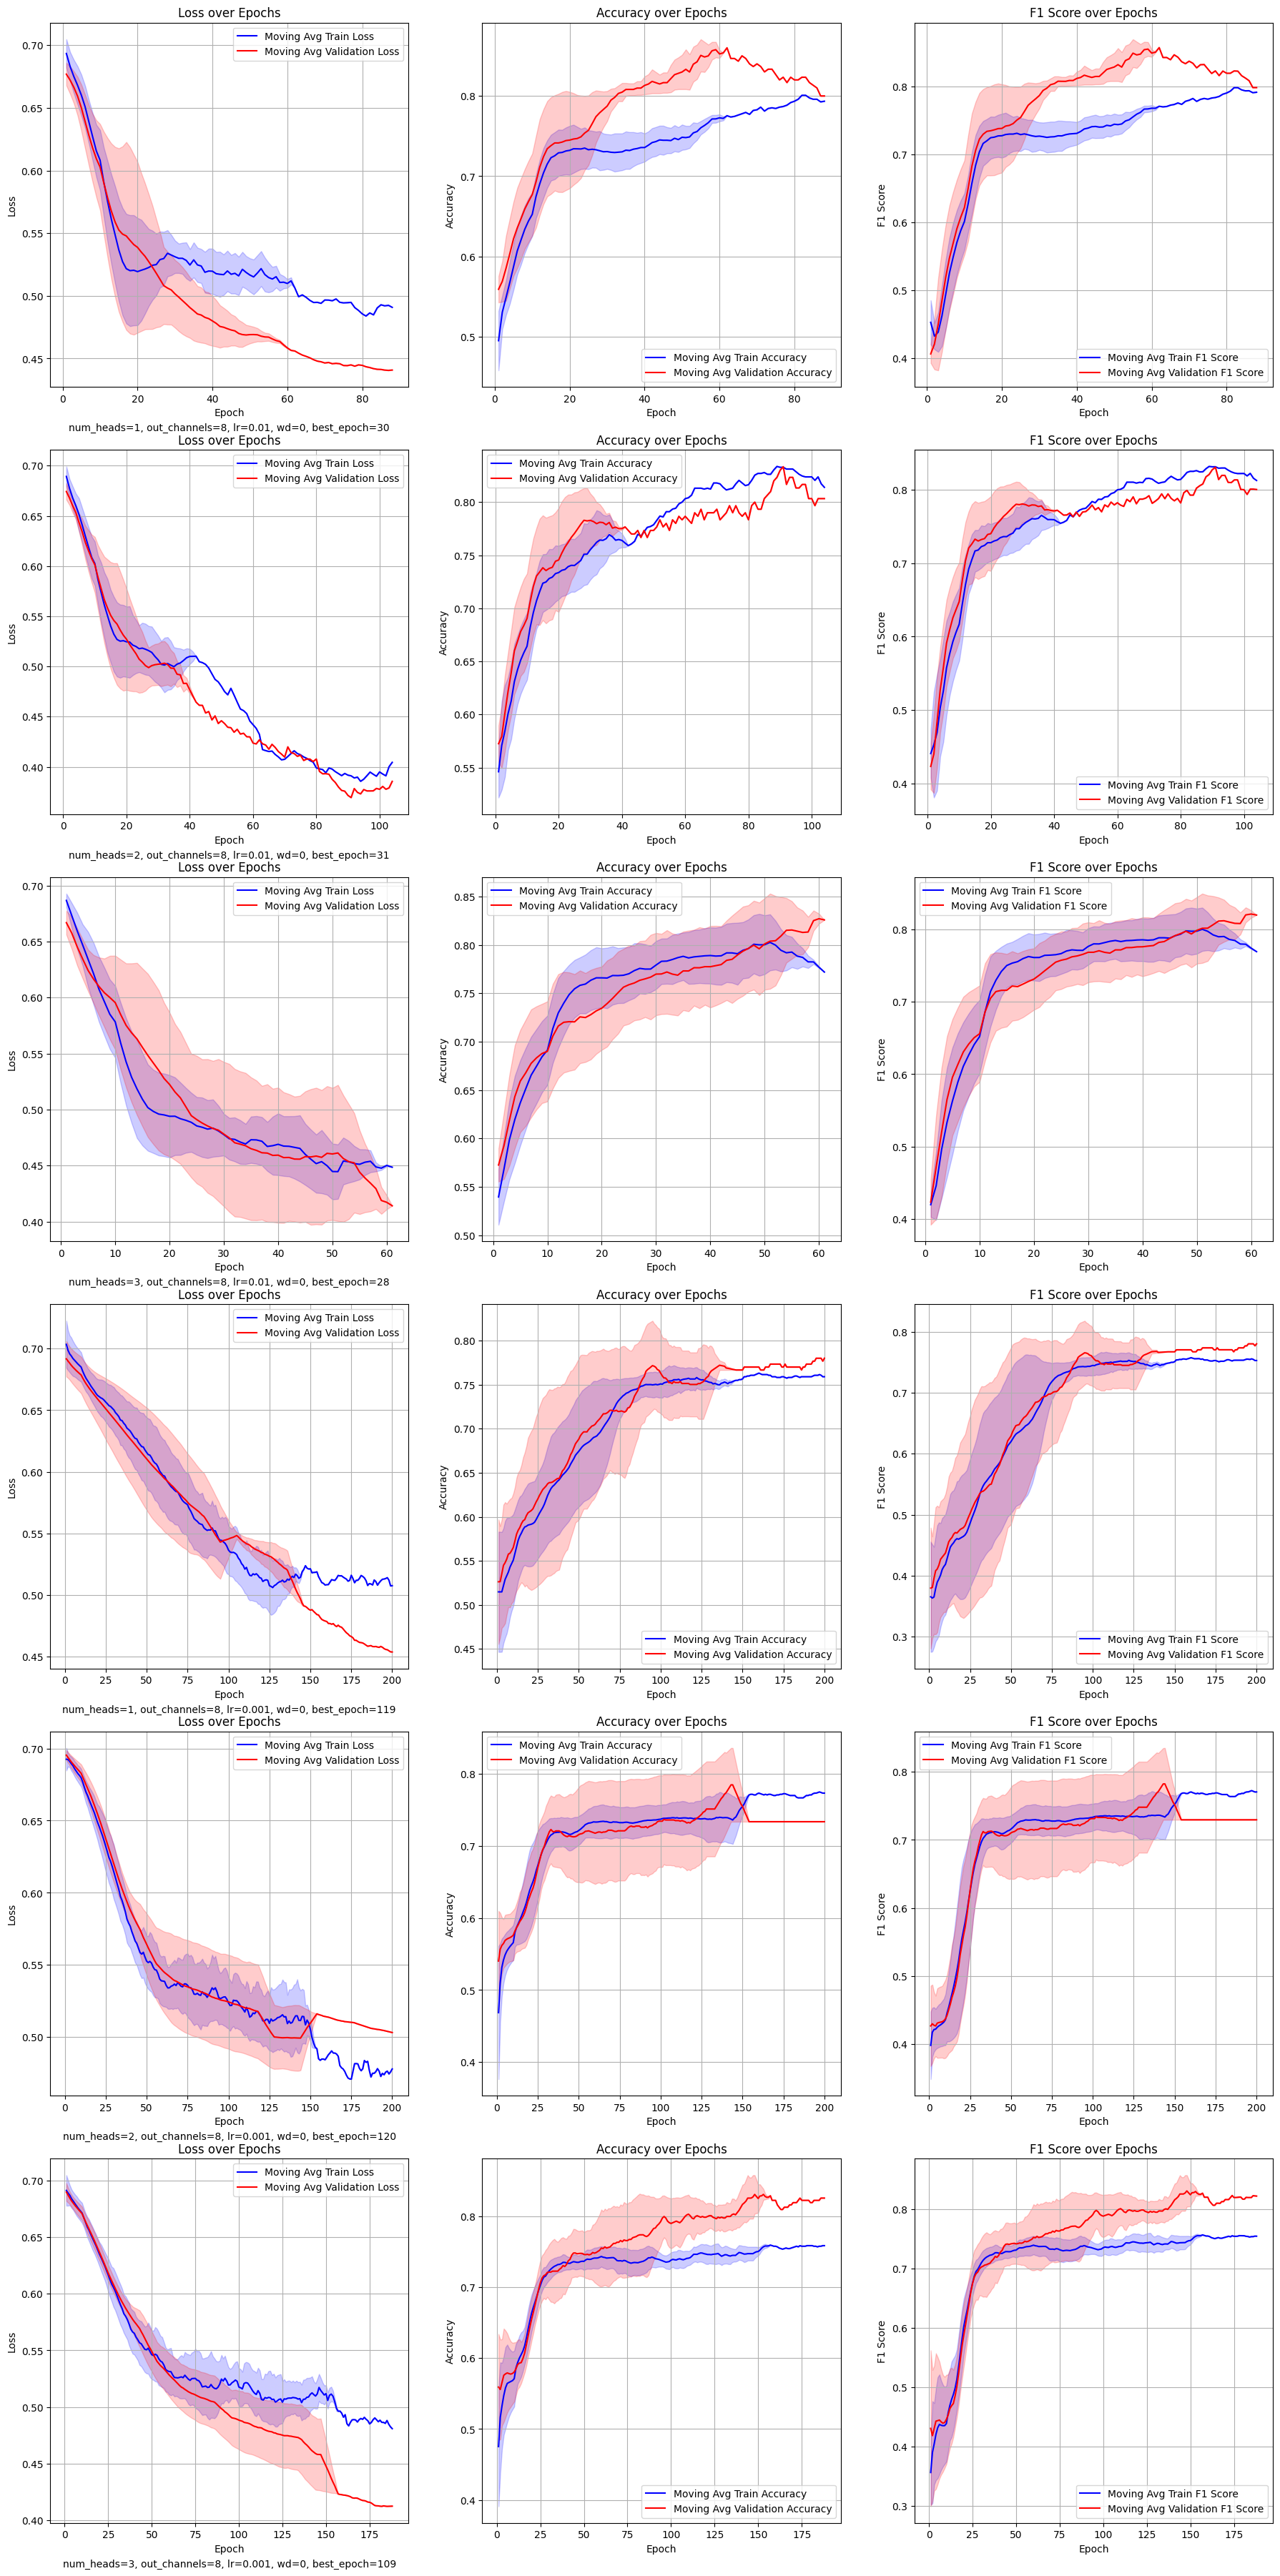

In [6]:
from perform_cv_early_stopping import perform_cv_early_stopping
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Perform grid search with K-fold cross-validation on the training set
best_params_1, best_val_f1_1, best_val_accuracy_1, best_epochs_trained_1, results_df_1 = perform_cv_early_stopping(
    train_graphs=train_graphs,
    train_labels=train_labels,
    num_splits=5,
    param_grid=param_grid_1,
    batch_size=8,
    device=device,
    patience = 10,
    max_epochs = 200
)

In [7]:
print("Best Hyperparameters (based on average validation F1):")
print(best_params_1)
print(f"Best Average Validation F1 Score: {best_val_f1_1}")
print(f"Best Average Validation Accuracy: {best_val_accuracy_1}")

Best Hyperparameters (based on average validation F1):
{'num_heads': 3.0, 'out_channels': 8.0, 'learning_rate': 0.001, 'weight_decay': 0.0}
Best Average Validation F1 Score: 0.7659535030113129
Best Average Validation Accuracy: 0.769247311827957


In [ ]:
# Save results_df to a CSV file for later analysis
#results_df_1.to_csv('first_grid_search_sc.csv', index=False)

In [12]:
best_params = {
    'num_heads': 3,
    'out_channels': 8,
    'learning_rate': 0.001,
    'weight_decay': 0
}

Epoch 1/109: Loss: 0.6947, F1: 0.2629
Epoch 2/109: Loss: 0.6830, F1: 0.5730
Epoch 3/109: Loss: 0.6714, F1: 0.6894
Epoch 4/109: Loss: 0.6624, F1: 0.6170
Epoch 5/109: Loss: 0.6555, F1: 0.5864
Epoch 6/109: Loss: 0.6503, F1: 0.5642
Epoch 7/109: Loss: 0.6460, F1: 0.5642
Epoch 8/109: Loss: 0.6398, F1: 0.6130
Epoch 9/109: Loss: 0.6345, F1: 0.6490
Epoch 10/109: Loss: 0.6289, F1: 0.6927
Epoch 11/109: Loss: 0.6224, F1: 0.7036
Epoch 12/109: Loss: 0.6165, F1: 0.6977
Epoch 13/109: Loss: 0.6104, F1: 0.7139
Epoch 14/109: Loss: 0.6045, F1: 0.7177
Epoch 15/109: Loss: 0.5982, F1: 0.7150
Epoch 16/109: Loss: 0.5922, F1: 0.7150
Epoch 17/109: Loss: 0.5880, F1: 0.7134
Epoch 18/109: Loss: 0.5837, F1: 0.7210
Epoch 19/109: Loss: 0.5778, F1: 0.7150
Epoch 20/109: Loss: 0.5741, F1: 0.7271
Epoch 21/109: Loss: 0.5709, F1: 0.7194
Epoch 22/109: Loss: 0.5690, F1: 0.7164
Epoch 23/109: Loss: 0.5676, F1: 0.7134
Epoch 24/109: Loss: 0.5614, F1: 0.7210
Epoch 25/109: Loss: 0.5602, F1: 0.7373
Epoch 26/109: Loss: 0.5569, F1: 0.

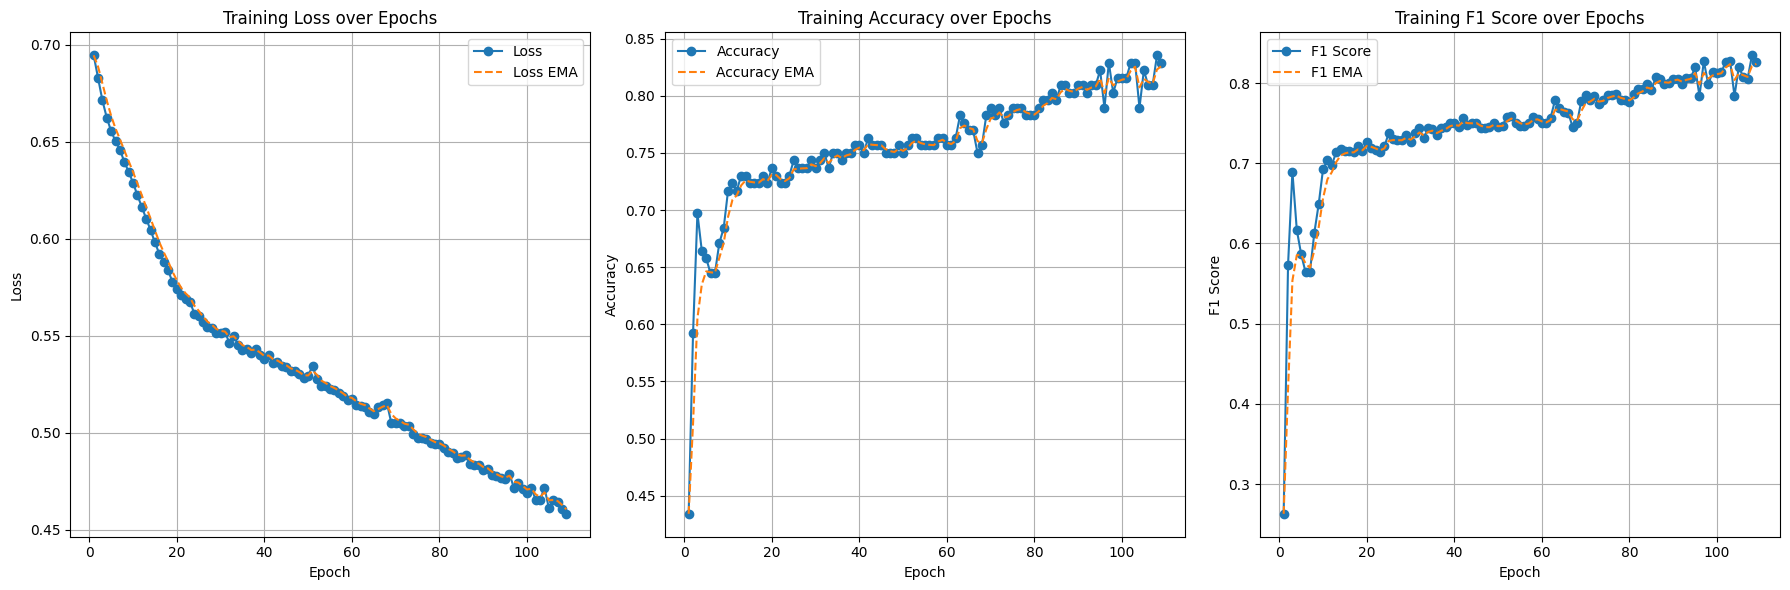

In [13]:
# train on all data

from train_all_data import train_model_on_all_data

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_model_on_all_data( 
    train_graphs, 
    train_labels, 
    dataset_name='sc',
    best_params = best_params, 
    max_epochs = 109, 
    batch_size=8, 
    device = device)

In [14]:
best_model_path = os.path.join(base_dir, 'src1', 'best_model_sc.pth')


from test_best_model import test_model
test_model(
    model_path=best_model_path,
    graphs=test_graphs,
    labels=test_labels
)

Test Loss: 0.4936, Test Accuracy: 0.7778, Test F1: 0.7784


In [5]:
import pandas as pd
results_df_1 = pd.read_csv('first_grid_search_sc.csv')

In [8]:
from performance_visualizations import get_top_results

top_results_df_1 = get_top_results(
    results_df=results_df_1,
    hyperparameters=['learning_rate', 'num_heads', 'weight_decay', 'out_channels'],
    metric='val_f1',
    percentile=5,
    print_flag=True
)

c:\Users\barbo\brain classifier repo\brain_classifier\src1\performance_visualizations.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_results_df[hyperparameters] = top_results_df[hyperparameters].round(3)


,fold,val_f1,learning_rate,num_heads,weight_decay,out_channels
110,1,0.871781,0.1,4,0.0,16
55,1,0.871781,0.1,2,0.0,16
70,1,0.839721,0.1,3,0.0,8
65,1,0.839392,0.1,3,0.0,8
20,1,0.839392,0.1,1,0.0,16
40,1,0.839392,0.1,2,0.0,8
0,1,0.837663,0.1,1,0.0,8
80,1,0.837663,0.1,3,0.0,16
30,1,0.837663,0.1,2,0.0,8
35,1,0.837663,0.1,2,0.0,8


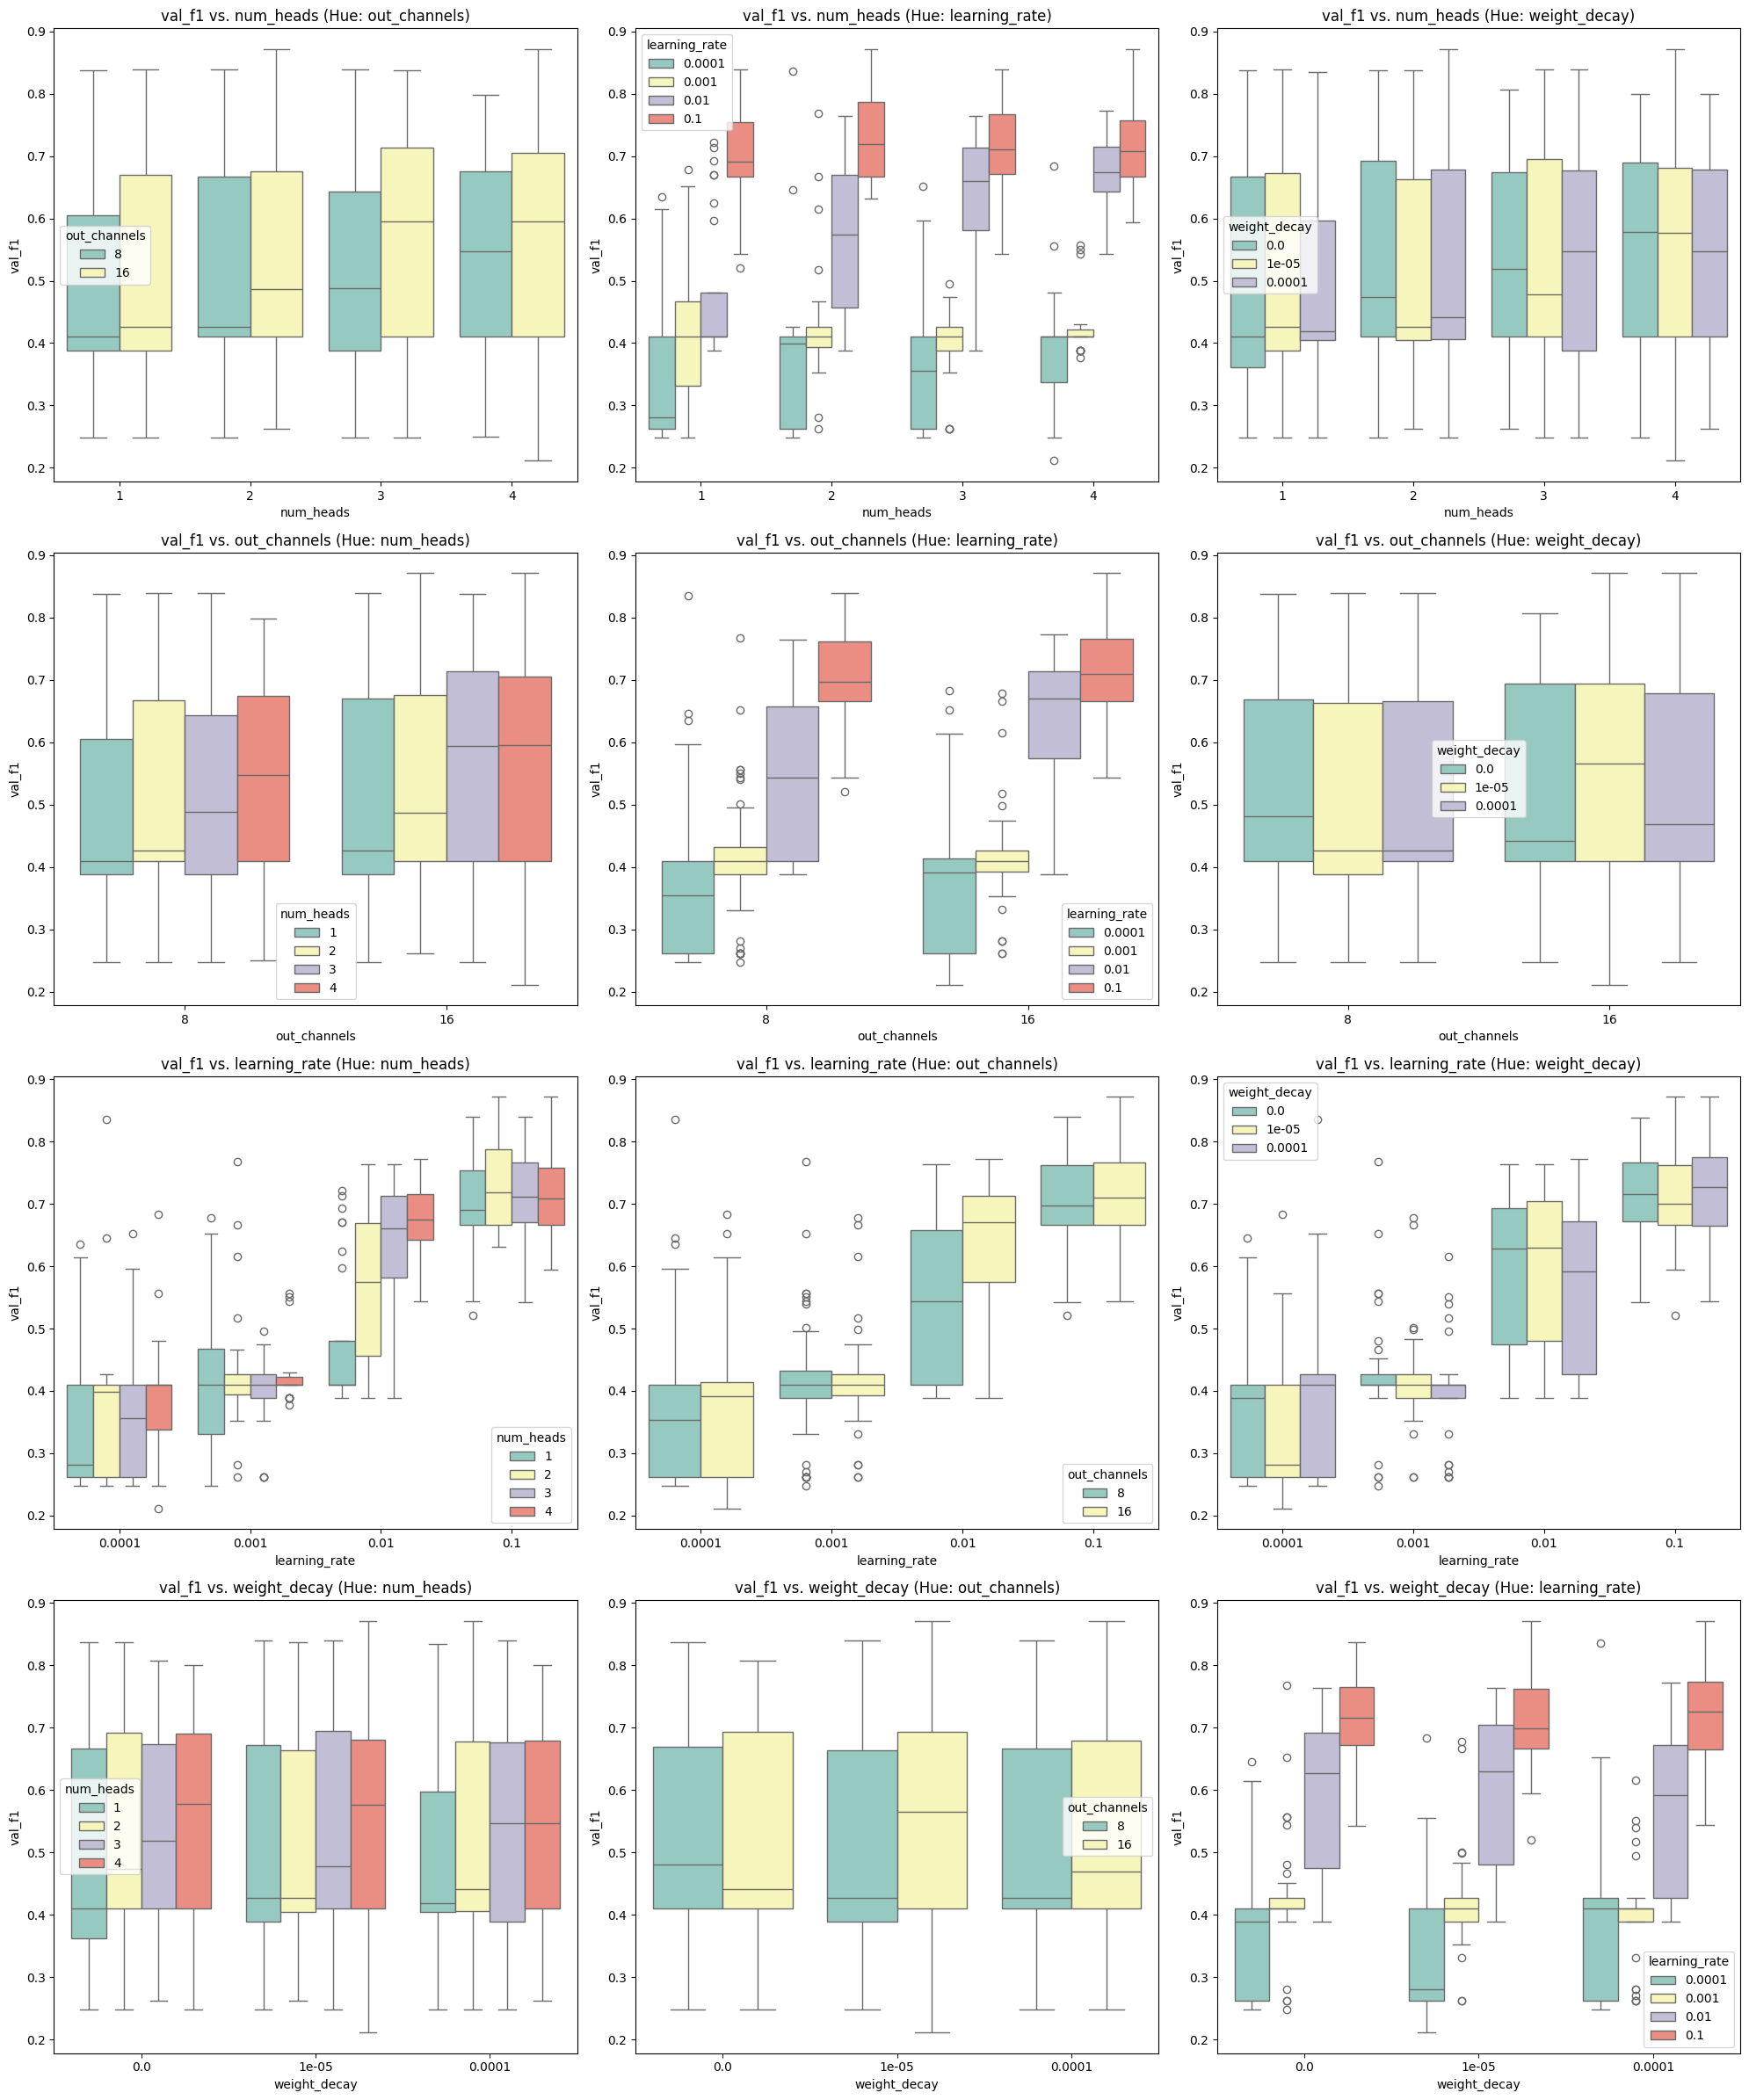

In [9]:
from performance_visualizations import plot_hyperparameter_boxplots
plot_hyperparameter_boxplots(
    results_df=results_df_1,
    hyperparameters=['num_heads', 'out_channels', 'learning_rate', 'weight_decay'],
    metric='val_f1',
    use_hue=True
)

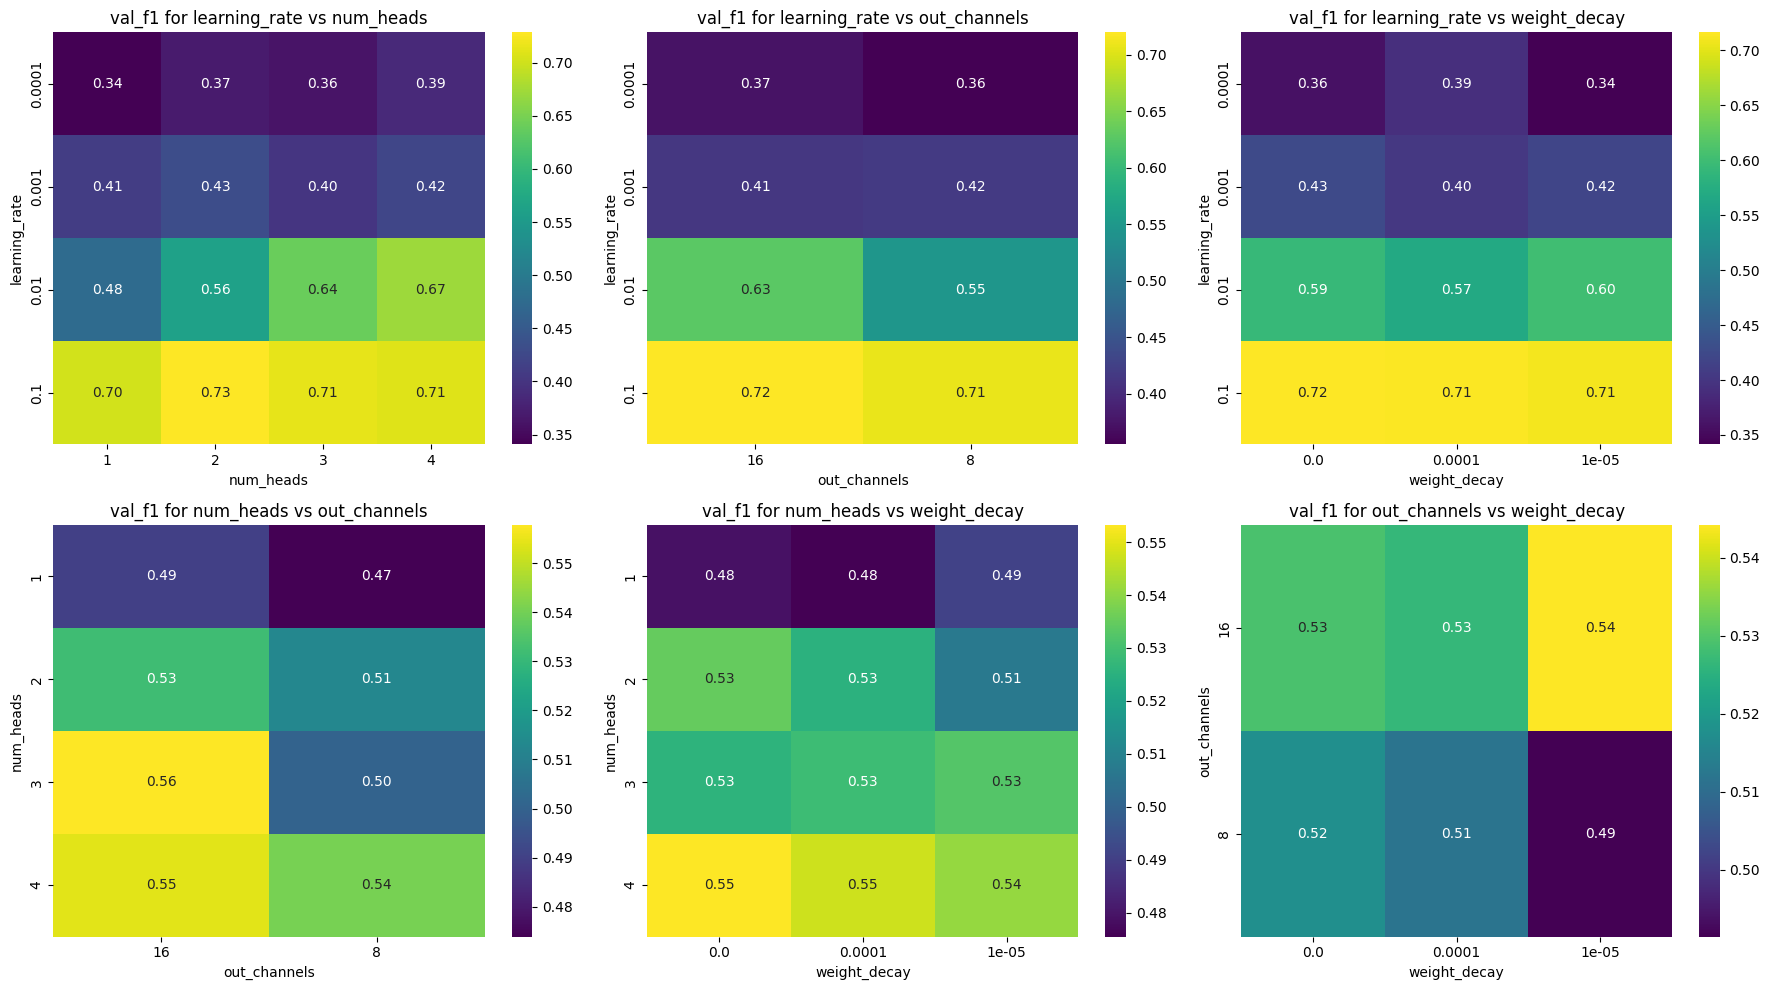

In [11]:
from performance_visualizations import plot_hyperparameter_heatmaps
plot_hyperparameter_heatmaps(
    results_df=results_df_1,
    hyperparameters=['learning_rate', 'num_heads', 'out_channels', 'weight_decay'],
    metric='val_f1'
)

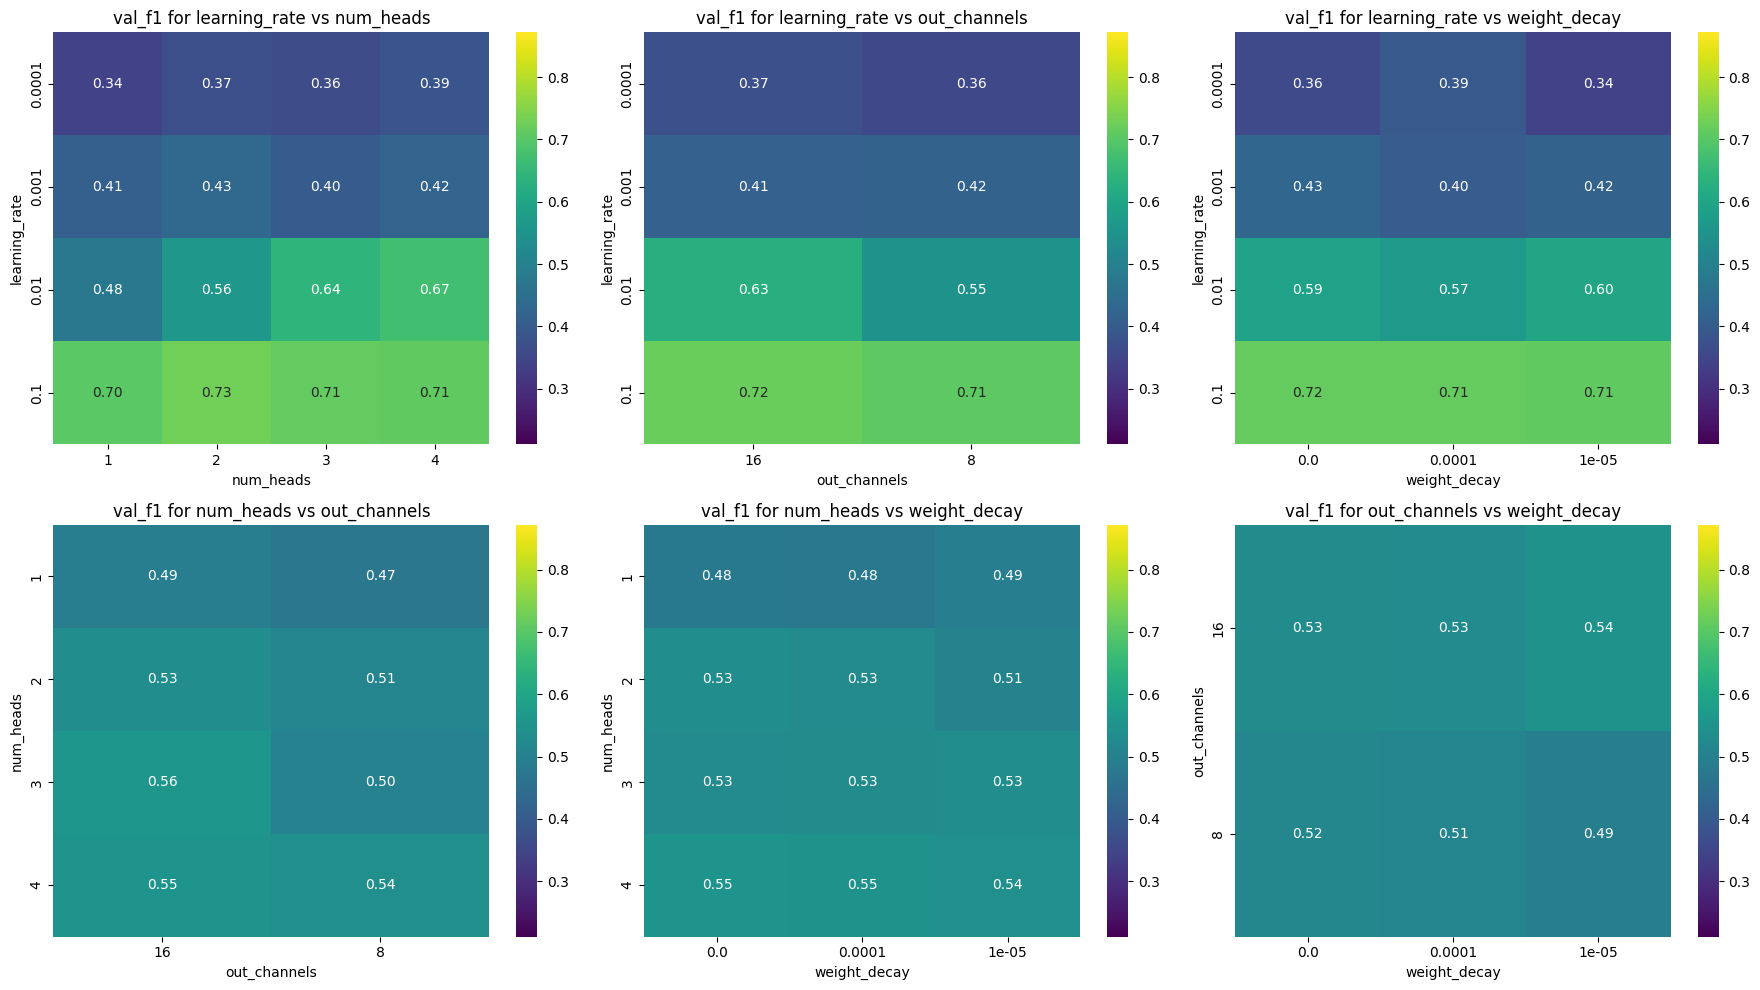

In [12]:
from performance_visualizations import plot_uniform_hyperparameter_heatmaps
plot_uniform_hyperparameter_heatmaps(
    results_df=results_df_1,
    hyperparameters=['learning_rate', 'num_heads', 'out_channels', 'weight_decay'],
    metric='val_f1'
)

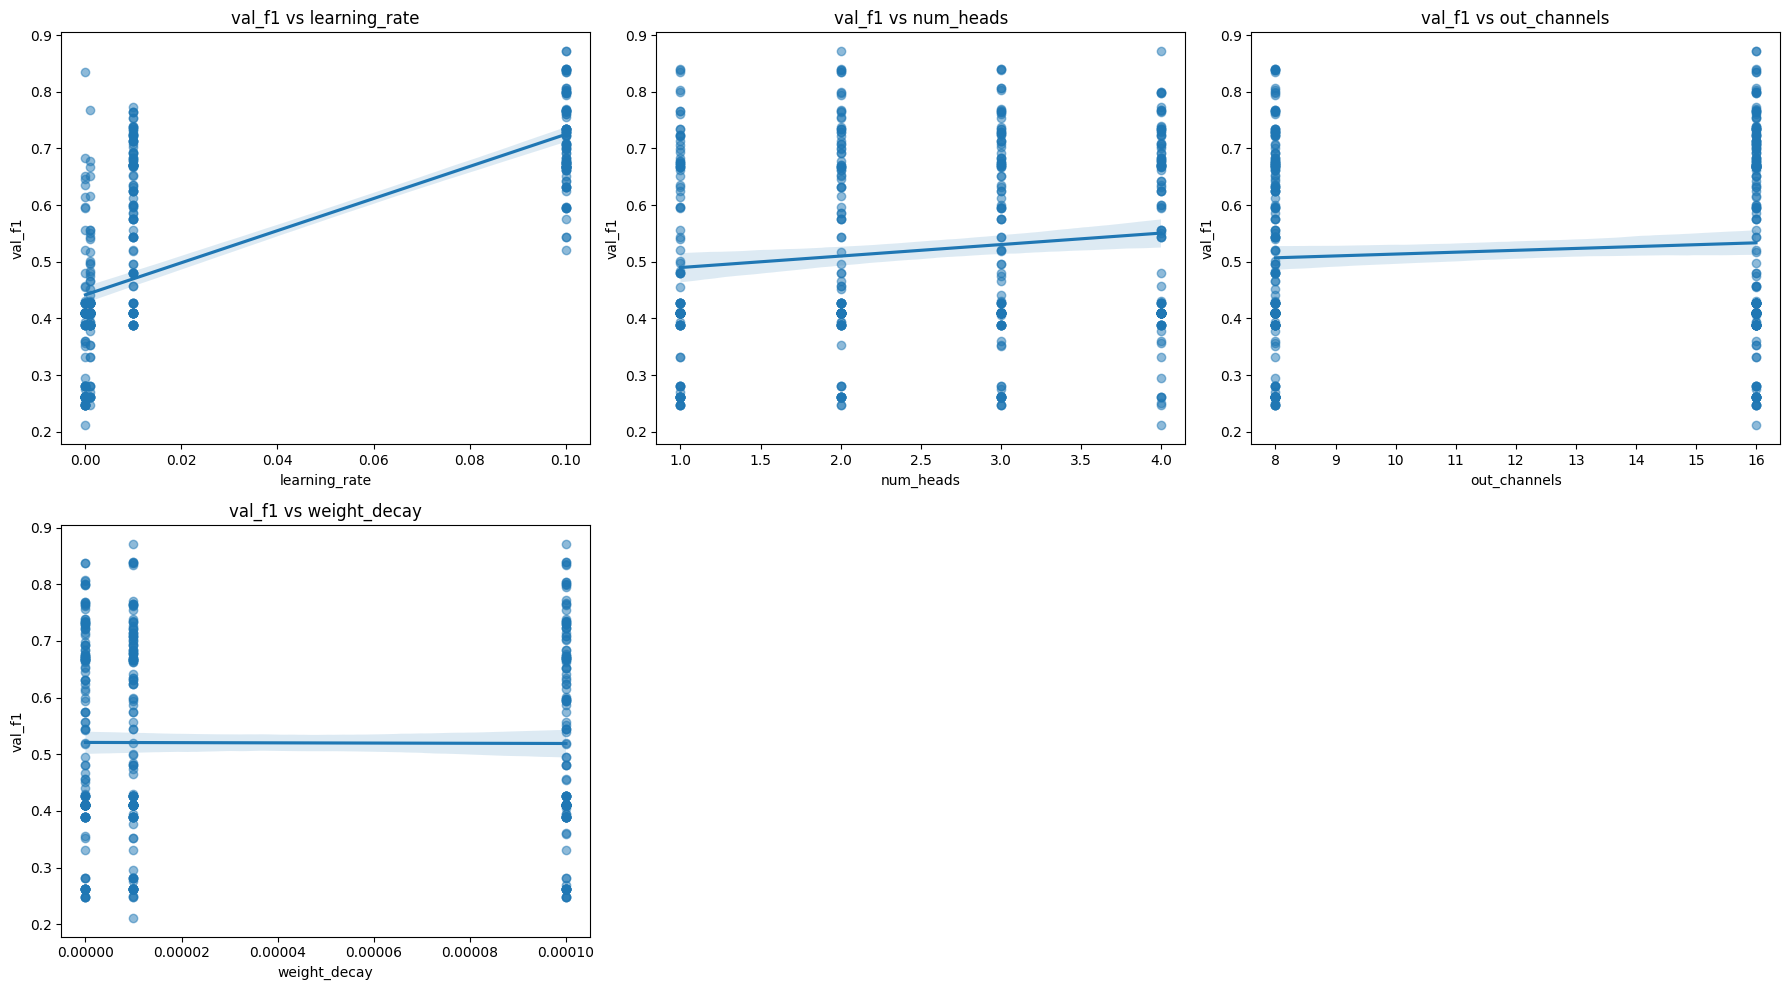

In [13]:
from performance_visualizations import plot_hyperparameter_scatterplots_with_regression
plot_hyperparameter_scatterplots_with_regression(
    results_df=results_df_1,
    hyperparameters=['learning_rate', 'num_heads', 'out_channels', 'weight_decay'],
    metric='val_f1'
)

In [13]:
# Second hyperparameter grid
param_grid = {
    'num_heads': [2,3],
    'out_channels': [16],
    'num_epochs': [10],
    'learning_rate': [1e-1, 1e-2],
    'weight_decay': [0, 1e-5]
}

In [15]:
# Perform second grid search with K-fold cross-validation on the training set
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
best_params_2, best_val_f1_2, best_val_accuracy_2, results_df_2 = perform_grid_search(
    train_graphs=train_graphs,
    train_labels=train_labels,
    num_splits=5,
    param_grid=param_grid,
    batch_size=32,
    model_class=GAT,
    device=device
)

In [16]:
print("Best Hyperparameters (based on average validation F1):")
print(best_params_2)
print(f"Best Average Validation F1 Score: {best_val_f1_2}")
print(f"Best Average Validation Accuracy: {best_val_accuracy_2}")

Best Hyperparameters (based on average validation F1):
{'num_heads': 2.0, 'out_channels': 16.0, 'learning_rate': 0.01, 'weight_decay': 1e-05}
Best Average Validation F1 Score: 0.7457026708713245
Best Average Validation Accuracy: 0.7501075268817204


In [ ]:
# Save results_df to a CSV file for later analysis
#results_df_2.to_csv('second_grid_search_sc.csv', index=False)
import pandas as pd
results_df_2 = pd.read_csv('second_grid_search_sc.csv')

In [19]:
from performance_visualizations import get_top_results

top_results_df_2 = get_top_results(
    results_df=results_df_2,
    hyperparameters=['learning_rate', 'num_heads', 'weight_decay', 'out_channels'],
    metric='val_f1',
    percentile=50,
    print_flag=True
)

c:\Users\barbo\brain classifier repo\brain_classifier\src1\performance_visualizations.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_results_df[hyperparameters] = top_results_df[hyperparameters].round(3)


,fold,val_f1,learning_rate,num_heads,weight_decay,out_channels
15,1,0.839392,0.10,3,0.0,16
5,1,0.839392,0.10,2,0.0,16
0,1,0.837663,0.10,2,0.0,16
10,1,0.803480,0.10,3,0.0,16
27,3,0.800893,0.01,2,0.0,16
32,3,0.800893,0.01,3,0.0,16
7,3,0.797222,0.10,2,0.0,16
25,1,0.772729,0.01,2,0.0,16
30,1,0.772729,0.01,3,0.0,16
21,2,0.764124,0.01,2,0.0,16


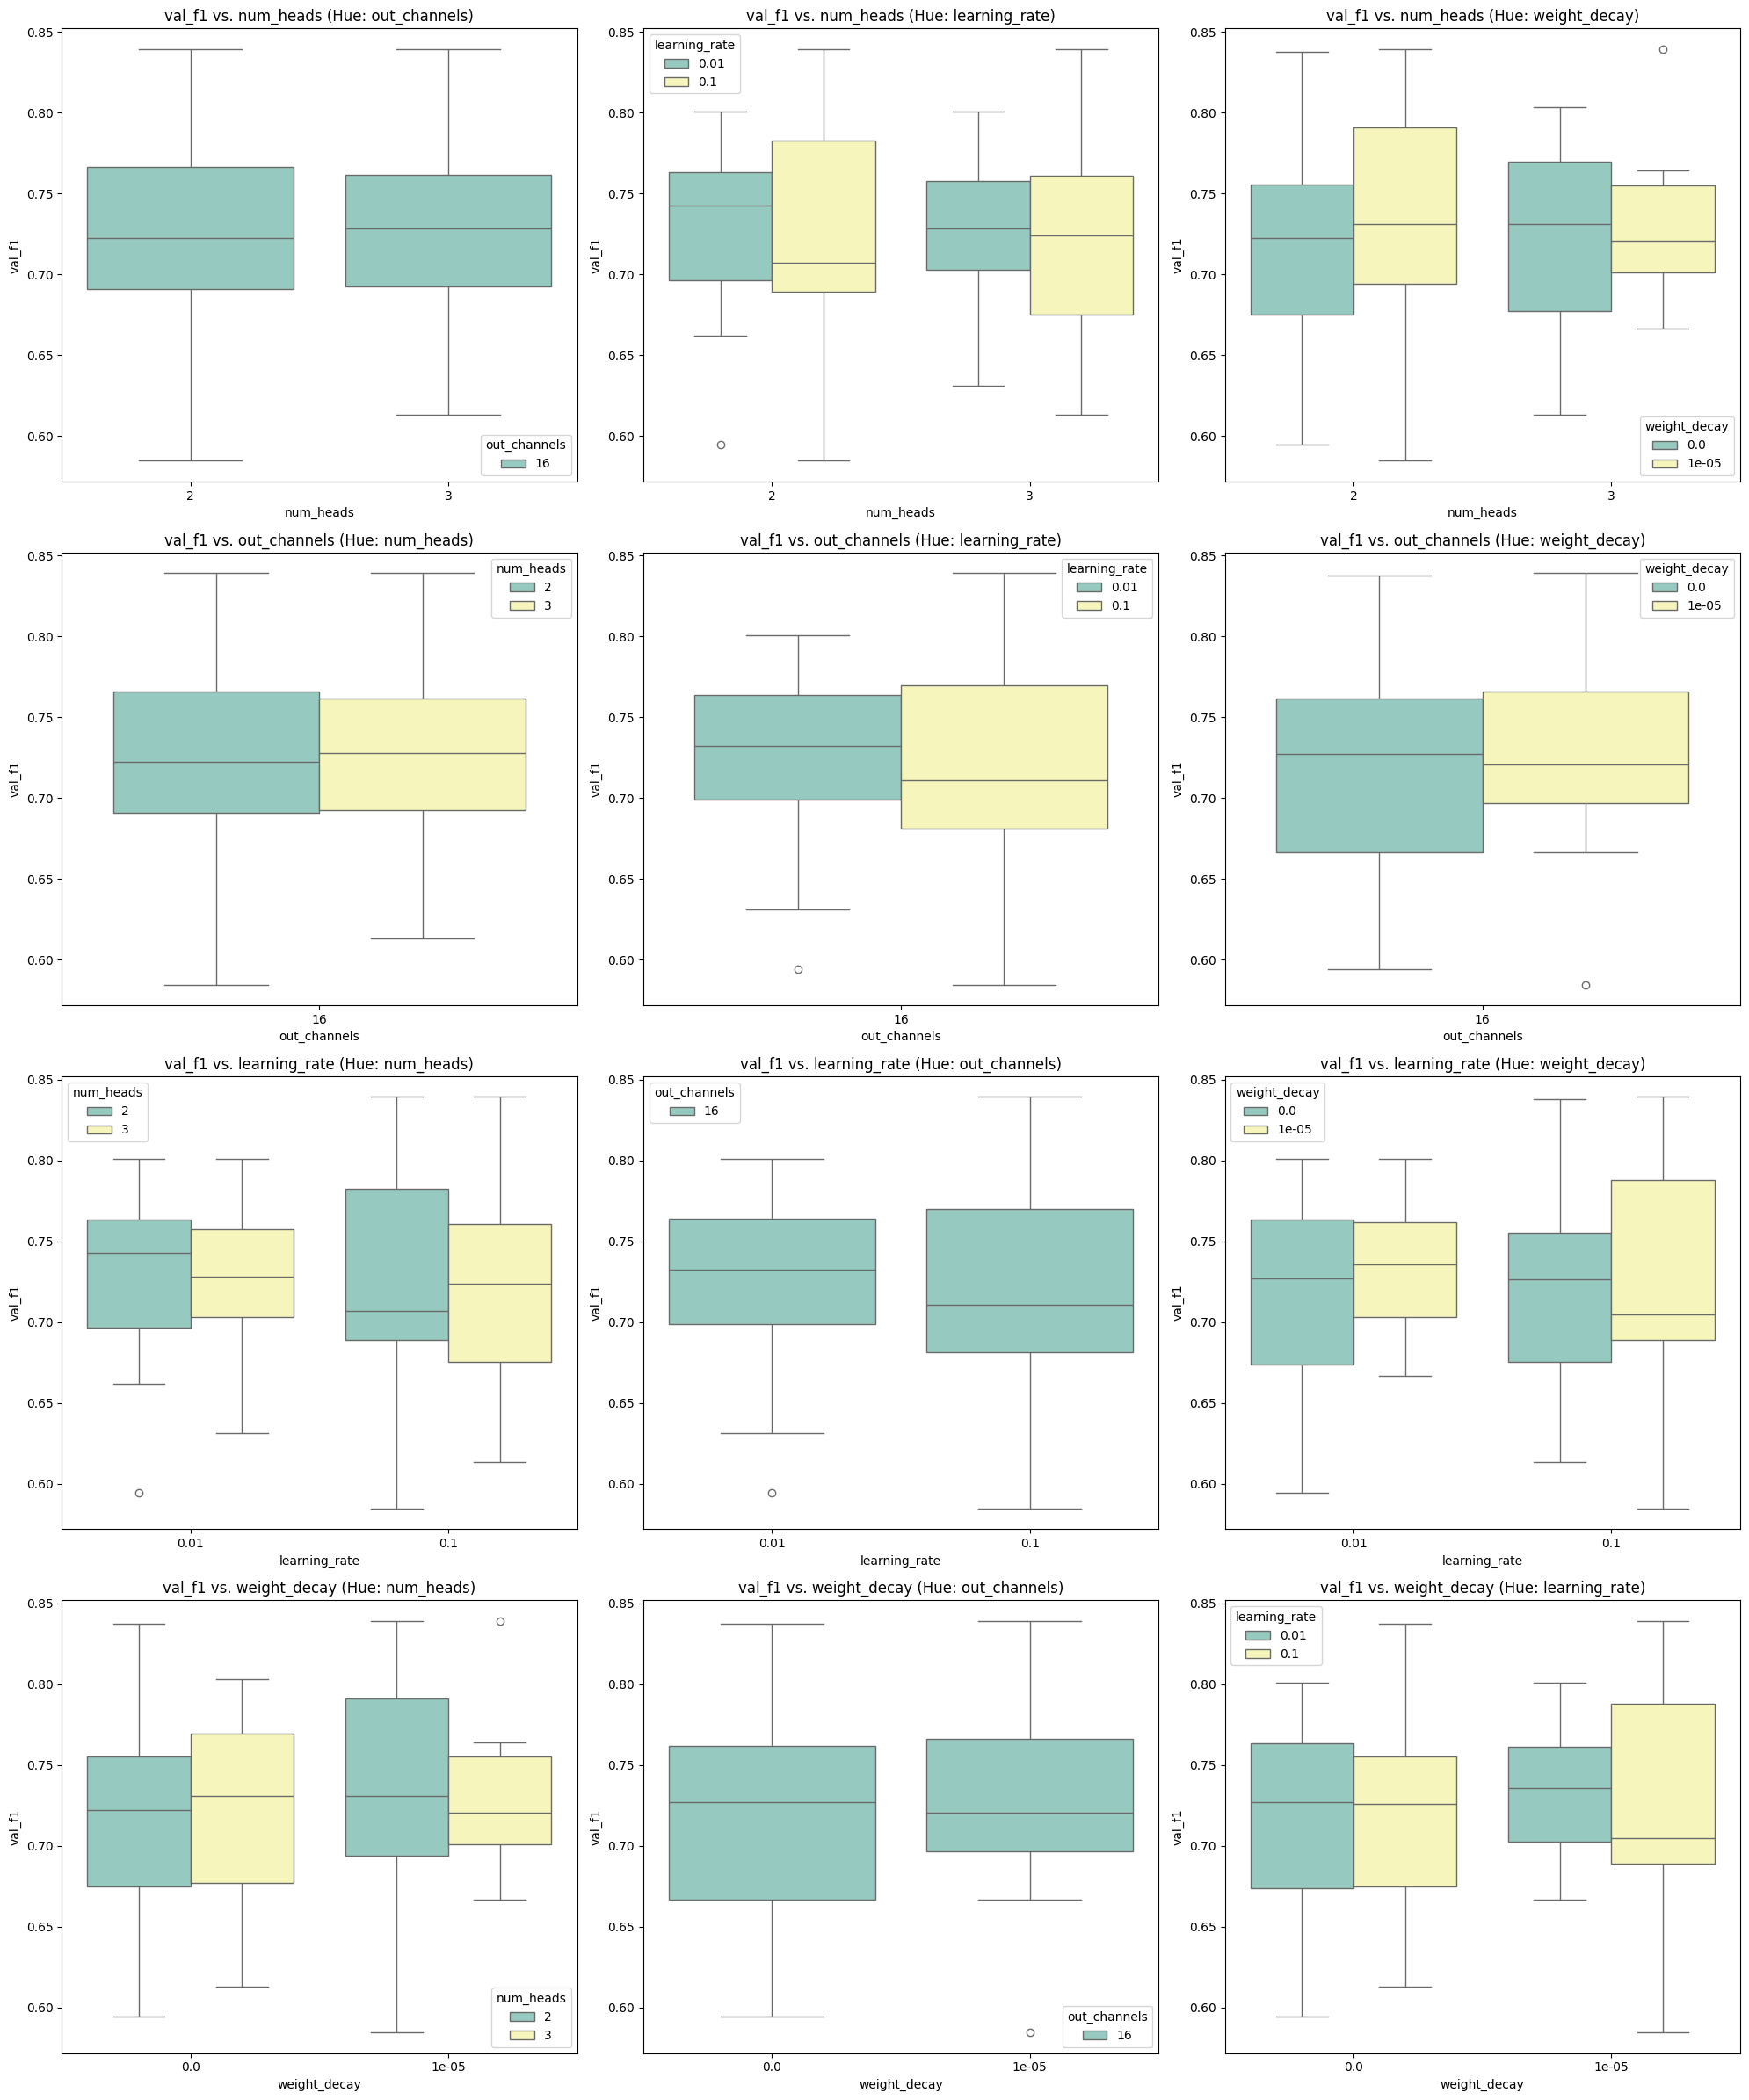

In [20]:
from performance_visualizations import plot_hyperparameter_boxplots
plot_hyperparameter_boxplots(
    results_df=results_df_2,
    hyperparameters=['num_heads', 'out_channels', 'learning_rate', 'weight_decay'],
    metric='val_f1',
    use_hue=True
)

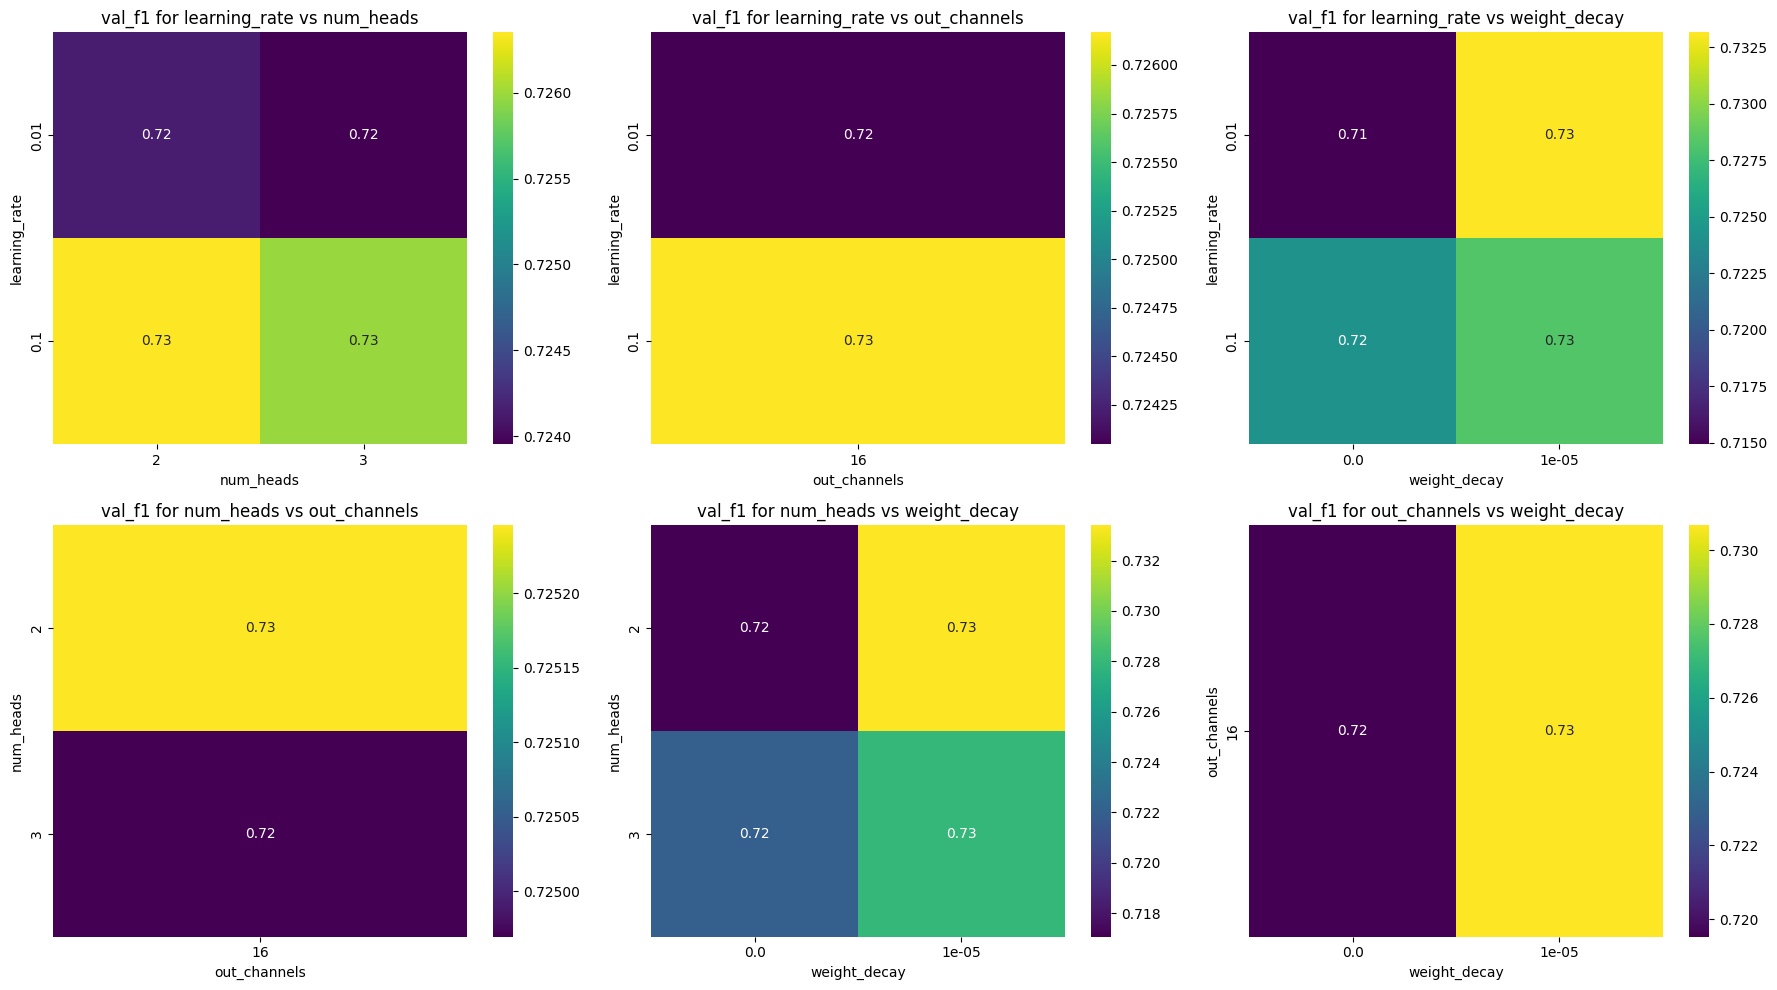

In [25]:
from performance_visualizations import plot_hyperparameter_heatmaps
plot_hyperparameter_heatmaps(
    results_df=results_df_2,
    hyperparameters=['learning_rate', 'num_heads', 'out_channels', 'weight_decay'],
    metric='val_f1'
)

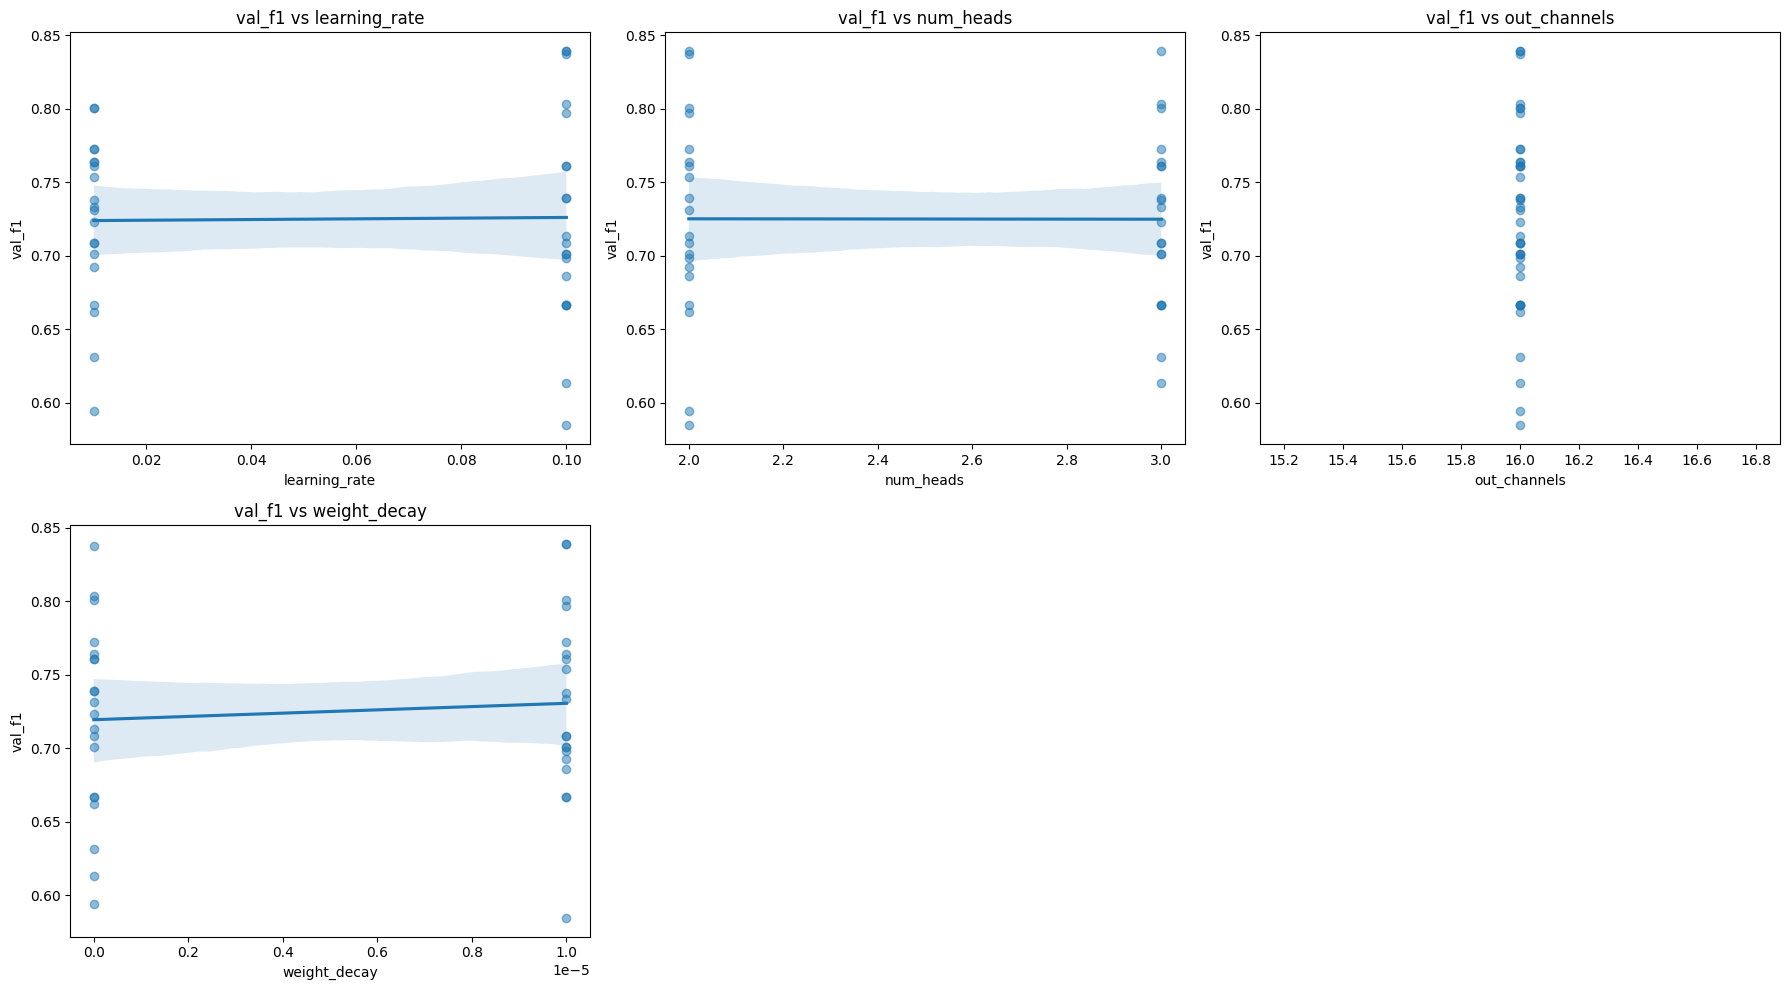

In [23]:
from performance_visualizations import plot_hyperparameter_scatterplots_with_regression
plot_hyperparameter_scatterplots_with_regression(
    results_df=results_df_2,
    hyperparameters=['learning_rate', 'num_heads', 'out_channels', 'weight_decay'],
    metric='val_f1'
)

In [10]:
# Train the best model with early stopping

# Set the best hyperparameters
best_params = {
    'num_heads': 2,
    'out_channels': 8,
    'learning_rate': 0.001,
    'weight_decay': 0
}



In [2]:
from prepare_datasets import prepare_datasets
import os
from build_dataloader import set_seed
# Set random seed for reproducibility
set_seed(42)
base_dir = os.path.dirname(os.getcwd())
# Prepare datasets
datasets, feature_names_sc, feature_names_combined = prepare_datasets(base_dir, test_size = 0.15, random_state = 42)

dataset_name = 'sc'
train_graphs = datasets[f'train_graphs_{dataset_name}']
train_labels = datasets[f'train_labels_{dataset_name}']
test_graphs = datasets[f'test_graphs_{dataset_name}']
test_labels = datasets[f'test_labels_{dataset_name}']

c:\Users\barbo\brain classifier repo\brain_classifier\.venv\lib\site-packages\torchdata\datapipes\__init__.py:18: UserWarning: 
################################################################################
WARNING!
The 'datapipes', 'dataloader2' modules are deprecated and will be removed in a
future torchdata release! Please see https://github.com/pytorch/data/issues/1196
to learn more and leave feedback.
################################################################################

  deprecation_warning()
c:\Users\barbo\brain classifier repo\brain_classifier\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Epoch 1/100: Train Loss: 0.6772, Val Loss: 0.6692, Train F1: 0.5638, Val F1: 0.5740
Epoch 2/100: Train Loss: 0.6733, Val Loss: 0.6661, Train F1: 0.5371, Val F1: 0.5740
Epoch 3/100: Train Loss: 0.6711, Val Loss: 0.6630, Train F1: 0.4644, Val F1: 0.5032
Epoch 4/100: Train Loss: 0.6682, Val Loss: 0.6604, Train F1: 0.4531, Val F1: 0.5032
Epoch 5/100: Train Loss: 0.6649, Val Loss: 0.6575, Train F1: 0.4531, Val F1: 0.5032
Epoch 6/100: Train Loss: 0.6636, Val Loss: 0.6551, Train F1: 0.4531, Val F1: 0.4221
Epoch 7/100: Train Loss: 0.6617, Val Loss: 0.6528, Train F1: 0.4846, Val F1: 0.5032
Epoch 8/100: Train Loss: 0.6602, Val Loss: 0.6501, Train F1: 0.5144, Val F1: 0.5740
Epoch 9/100: Train Loss: 0.6568, Val Loss: 0.6476, Train F1: 0.5287, Val F1: 0.5740
Epoch 10/100: Train Loss: 0.6548, Val Loss: 0.6453, Train F1: 0.5287, Val F1: 0.5740
Epoch 11/100: Train Loss: 0.6530, Val Loss: 0.6420, Train F1: 0.6018, Val F1: 0.5740
Epoch 12/100: Train Loss: 0.6532, Val Loss: 0.6393, Train F1: 0.5832, Val 

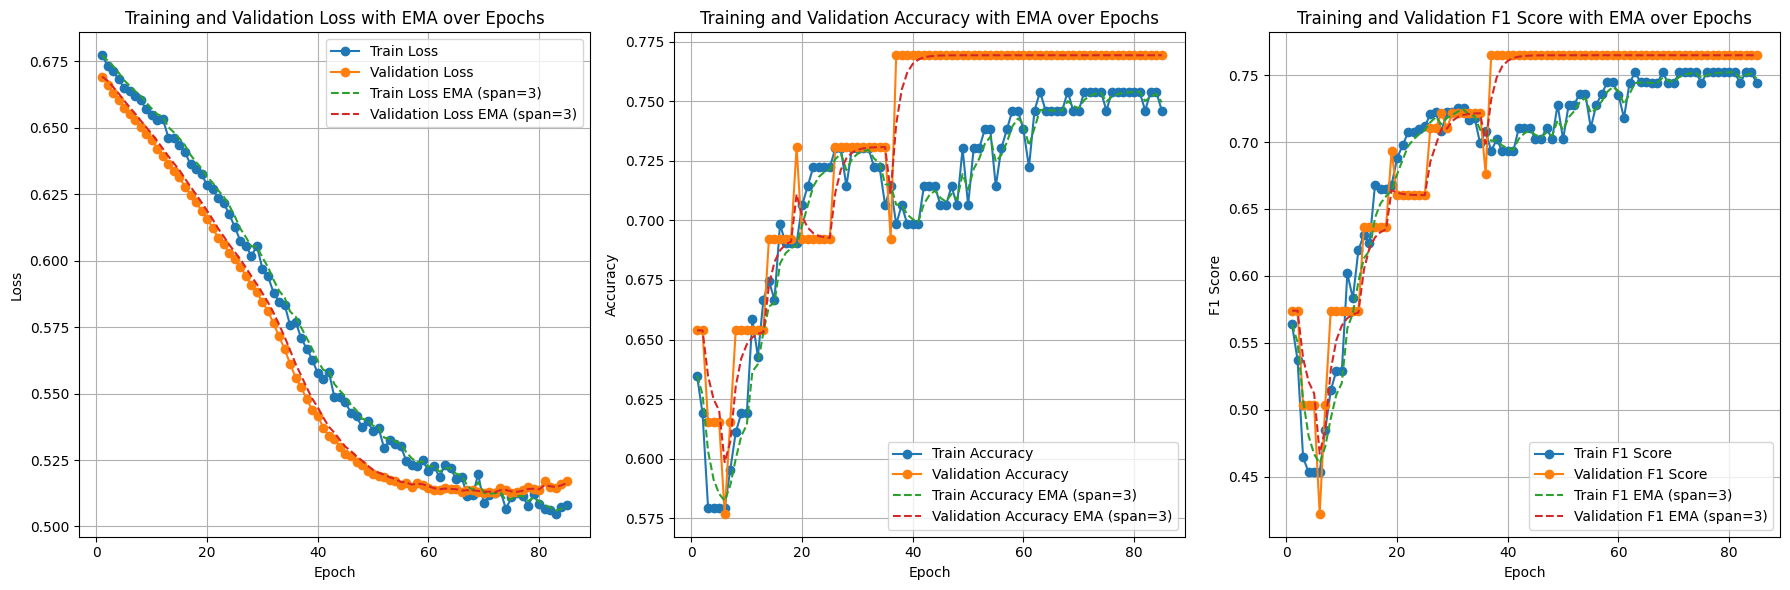

In [11]:
from train_best_model import train_model_with_early_stopping
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_model_with_early_stopping(
    train_graphs, 
    train_labels, 
    dataset_name='sc',
    best_params = best_params, 
    patience=10, 
    max_epochs = 100, 
    batch_size=8, 
    device = device)

In [12]:
best_model_path = os.path.join(base_dir, 'src1', 'best_model_sc.pth')

In [13]:
from test_best_model import test_model
test_model(
    model_path=best_model_path,
    graphs=test_graphs,
    labels=test_labels
)

Test Loss: 0.3974, Test Accuracy: 0.8889, Test F1: 0.8883
